# Combination investigation

this notebook investigates the distribution of block combinations in the dataset, which will guide architecture decisions

In [1]:
import os
import matplotlib.pyplot as plt
import json # .dat files are actually json
import numpy as np
from functools import reduce, partial
import math

In [2]:
# Define difficulty based on _difficultyRank present in info.dat

DIFFICULTIES = {
    "Easy": [1,2],
    "Normal": [3,4],
    "Hard": [5,6],
    "Expert": [7,8],
    "Expert+": [9]
}

In [3]:
# Analysis parameters

DIFFICULTY = "Expert+"
# DIFFICULTY = "Easy"


In [4]:
rootDirs = ["data/raw/CustomLevels/", "../data/raw/CustomLevels/"]
for rd in rootDirs:
    if os.path.isdir(rd):
        rootDir = rd
        break

songs = os.listdir(rootDir)
print(f"{len(songs)} songs in the folder")
assert len(songs) > 0, "Folder doesn't contain any songs"

504 songs in the folder


In [5]:
# Make a list of all mappings of the specified difficulty rating

mappings = []

for song in songs:
    try:
        with open(os.path.join(rootDir, song, "info.dat")) as f:
            info = json.load(f)
        for dbs in info['_difficultyBeatmapSets']:
            for db in dbs['_difficultyBeatmaps']:
                if db['_difficultyRank'] in DIFFICULTIES[DIFFICULTY]:
                    mappings.append(os.path.join(rootDir, song, db['_beatmapFilename']))
    except Exception as e:
        print(e)
        
print(f"{len(mappings)} mappings left after difficulty filtering")
assert len(mappings) > 0, "mappings should have at least one mapping"

250 mappings left after difficulty filtering


In [6]:
# Load the note lists for each song into memory

noteLists = {}

for mapping in mappings:
    with open(mapping) as f:
        noteLists[mapping] = json.load(f)['_notes']

### Notes

Notes contain the following information:

* "_time": the time step (seconds) when the event happens
* "_lineIndex": the column of the note (?)
* "_lineLayer": the row of the note (?)
* "_type": the colour of the note
* "_cutDirection": the direction in which to cut the note

Multiple notes can appear at the same timestep

#### Positions

```
_cutDirection
↖↑↗  4 0 5
←o→  2 8 3
↙↓↘  6 1 7

_lineLayer
2
1
0 1 2 3 _lineIndex
```

(Info obtained by experimenting)

### Analysis pt. 1

I don't know anything about mapping files and have never created one "the normal way". I think there should be 3 rows of 4 columns, but I need to first test this.


In [7]:
all_note_positions = []
memeSongs = []
for songTitle, songNotes in noteLists.items():
    # add them here first so we can not add them if it's a meme song later
    songNotePositions = []
    for note in songNotes:
        lineIndex, lineLayer = note['_lineIndex'],  note['_lineLayer']
        # keep it reasonable for songs that go overboard
        if lineIndex < -5 or lineIndex > 7 or lineLayer < -3 or lineLayer > 5:
            print(f"{songTitle} over limit")
            memeSongs.append(songTitle)
            break
        else:
            songNotePositions.append({"LI": lineIndex, "LL": lineLayer})
    all_note_positions.extend(songNotePositions)

../data/raw/CustomLevels/4e8d (Centipede (VISUAL) - nicetomeetyou)/ExpertPlus.dat over limit
../data/raw/CustomLevels/645a (A B Y S S - rustic)/ExpertPlusStandard.dat over limit
../data/raw/CustomLevels/97ac (Unholy Crusade - cyansnow)/ExpertPlusStandard.dat over limit
../data/raw/CustomLevels/8eec (LA Devotee - night)/ExpertPlusStandard.dat over limit


In [8]:
miLI = min([a['LI'] for a in all_note_positions])
maLI = max([a['LI'] for a in all_note_positions])
miLL = min([a['LL'] for a in all_note_positions])
maLL = max([a['LL'] for a in all_note_positions])

print(f"min lineIndex : {miLI}")
print(f"max lineIndex : {maLI}")
print(f"min lineLayer : {miLL}")
print(f"max lineLayer : {maLL}")

min lineIndex : -2
max lineIndex : 5
min lineLayer : 0
max lineLayer : 2



#### for my songs on Expert+:

* min lineIndex : -2
* max lineIndex : 5
* min lineLayer : 0
* max lineLayer : 2

Seems like reasonable songs only use 3 rows and at most 8 columns

### Analysis pt. 2

number of locations:

$ n_{loc8} = \_lineIndex \cdot \_lineLayer = 8 \cdot 3 = 24 $

number of block types:

$ n_{block} = \_type \cdot \_cutDirection = 2 \cdot 9 = 18 $

The max number of states for a block is:

$ b_1 = n_{loc8} \cdot n_{block} = 432$

However, multiple blocks are allowed. This means the total number of possible arrangements at one time step are:

$ b_{all} = (n_{block} + 1)^{n_{loc8}} >10^{30} $


Let's analyse the block positions to see if any can be discarded


In [9]:
# initialise heatmap as matrix of 0's
heatMap = np.zeros((maLL-miLL+1, maLI-miLI+1), dtype="uint32")

for note in all_note_positions:
    heatMap[note['LL'] - miLL ][note['LI'] - miLI ] += 1

# print the matrix (upside down, since layer 0 is the ground layer)
print(heatMap[::-1])

[[  270   310  9269 11011 10995  9679   307   259]
 [  298   394 23120  2856  2830 24285   369   273]
 [  522   525 30075 50003 49612 25013   499   471]]


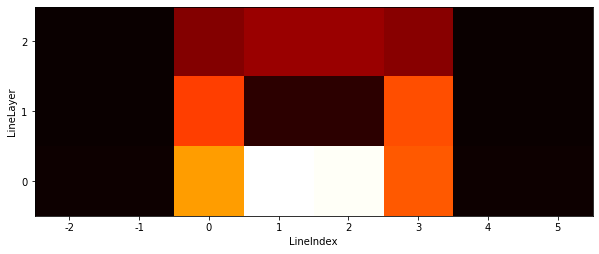

In [10]:
# plot the heatmap (upside down, since layer 0 is the ground layer)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.imshow(heatMap, cmap="hot", origin="lower", )
ax.set_xlabel("LineIndex")
ax.set_ylabel("LineLayer")
ax.set_xticks(range(0, maLI - miLI + 1))
ax.set_xticklabels(range(miLI, maLI + 1))
ax.set_yticks(range(0, maLL - miLL + 1))
ax.set_yticklabels(range(miLL, maLL + 1))
plt.show()

It seems that the extended two blocks on each side are almost never used; they can be discarded for simplicity. Updating:

number of locations:

$ n_{loc} = \_lineIndex \cdot \_lineLayer = 4 \cdot 3 = 12 $

The max number of states for a block therefore drops down to:

$ b_1 = n_{loc} \cdot n_{block} = 216$

And all possible arrangements for a time step, allowing everything:

$ b_{all} = (n_{block} + 1)^{n_{loc}} > 10^{15} $

still a huge number. Let's only allow at most 2 blocks, one for the right hand and one for the left hand.

$ b_{2} = \_cutDirection^2 \cdot n_{loc} \cdot (n_{loc} - 1) = 10692 $


### Common configuration analysis


Presumably not all of these combinations are represented. Let's perform an analysis on the common configurations.

Keep only at most one block per time step per left/right hand. If multiple, take the lowest. However, prioritise having a cut direction

Skip meme songs

In [11]:
# Reduce each song from a list of notes to a list of lists of notes, where notes with the same time step are together

def songNotesTogether(a,b):
    if len(a) != 0 and a[-1][-1]['_time'] == b['_time']:
        a[-1].append(b)
    else:
        a.append([b])
    return a

def songNotesTogetherWrapper(noteList):
    return reduce(songNotesTogether, noteList, [])

In [12]:
# sorting to ensure identical configs are the same

def noteSortKey(note):
    hasDirection = 0 if note['_cutDirection'] == 8 else 1
    
    lrkey = note['_lineIndex']
    if note['_type'] == 1:
        # right
        lrkey = 3 - note['_lineIndex']
    return (hasDirection, note['_lineLayer'], lrkey)
        

def sortNotesOnSameTimestamp(tsnotes):
    return sorted(tsnotes, key=noteSortKey)

def sortSongNotesWrapper(notes):
    return map(sortNotesOnSameTimestamp, notes)

In [13]:
# For each time step, make the configuration using bit shifting

# first 2 bits for LL
# second 2 bits for LI
# final 4 bits for cut direction
# first 8 bits left, last 8 bits right
# => 16 bit id

def makeConfigForNote(note):
    config = 0
    if note != None:
        config += note['_lineLayer']<<6
        config += note['_lineIndex']<<4
        config += note['_cutDirection']
    return config
    
def makeConfigForTS(notes):
    left = None
    right = None
    for note in notes:
        if left == None and note['_type'] == 0:
            left = note
        elif right == None and note["_type"] == 1:
            right = note
    
    config = 0
    config += makeConfigForNote(left) << 8
    config += makeConfigForNote(right)
    return config

def makeConfigForTSWrapper(song): 
    return map(makeConfigForTS, song)


In [14]:
# entire processing
configLists = list(map(makeConfigForTSWrapper, map(sortSongNotesWrapper, map(songNotesTogetherWrapper, noteLists.values()))))

In [15]:
# Finally, count them in a map
distrib = {}

for song in configLists:
    for config in song:
        if config not in distrib:
            distrib[config] = 0
        distrib[config] += 1

In [16]:
items = sorted(distrib.values(), reverse=True)

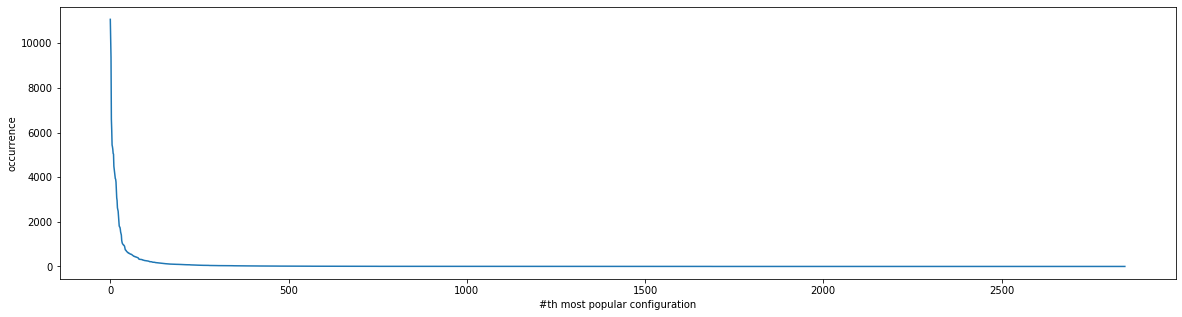

In [17]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(items)
ax.set_xlabel("#th most popular configuration")
ax.set_ylabel("occurrence")
plt.show()

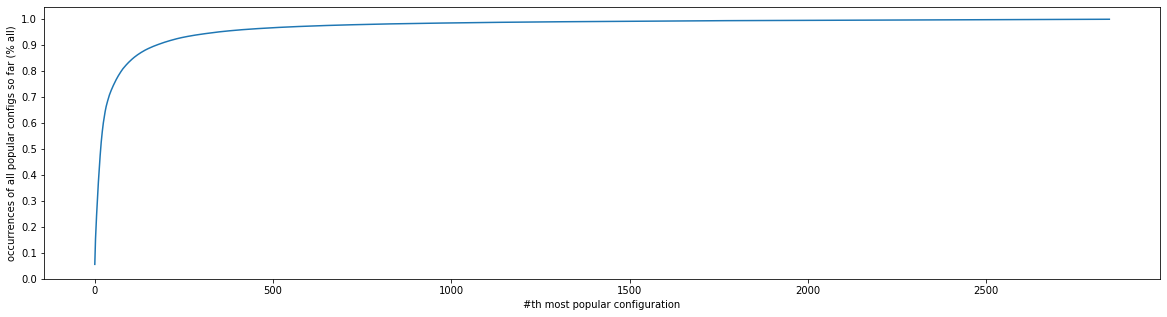

In [18]:
# plot the percentage of all configs encompassed by all configurations so far

def reduceSumSoFar(a,b):
    if len(a) == 0:
        return [b]
    a.append(a[-1]+b)
    return a

sumsSoFar = reduce(reduceSumSoFar,items,[])

num_yticks = 10

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(sumsSoFar)
ax.set_xlabel("#th most popular configuration")
ax.set_ylabel("occurrences of all popular configs so far (% all)")
ax.set_yticks([i*sumsSoFar[-1]/num_yticks for i in range(num_yticks + 1)])
ax.set_yticklabels([x/num_yticks for x in range(num_yticks + 1)])
plt.show()

In [19]:
tot_combinations = sum(items)
print(f"There are {len(items)} total number of unique combinations, making up {tot_combinations} events")
for i in range(1, round(math.sqrt(len(items))), 5):
    print(f"first {i*i:5d} most popular configs represent {100*sum(items[:i*i])/tot_combinations:.3f}% of the total")

There are 2847 total number of unique combinations, making up 198848 events
first     1 most popular configs represent 5.568% of the total
first    36 most popular configs represent 68.035% of the total
first   121 most popular configs represent 86.310% of the total
first   256 most popular configs represent 93.245% of the total
first   441 most popular configs represent 96.240% of the total
first   676 most popular configs represent 97.700% of the total
first   961 most popular configs represent 98.508% of the total
first  1296 most popular configs represent 99.024% of the total
first  1681 most popular configs represent 99.411% of the total
first  2116 most popular configs represent 99.632% of the total
first  2601 most popular configs represent 99.876% of the total


## Insight

In practice, a small number of configurations is popular. Furthermore, being able to output a configuration as 16 bits loosens constraints on the architecture, since 16 output neurons can be used to print an entire configuration, without needing complex decoders. However, due to the encoding, care must be taken that the model is able to understand the meaning of bits: cutDirection 2 (0b0010) and 3 (0b0011) are highly similar, while the switch between the two may completely break the flow of the song. 